# Loan Default Prediction

This notebook walks through the process of cleaning data, feature engineering, and training a model to predict loan defaults using the LendingClub dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import warnings

warnings.filterwarnings('ignore')

## 1. Load Data

This is a very large file (~2.2M rows). Loading and processing can be slow and memory-intensive.
For initial exploration, you might want to load a sample by uncommenting the second line below.

In [11]:
try:
    # For full analysis
    print("Loading the full dataset... This may take a few minutes.")
    df = pd.read_csv("../02_data/raw/accepted_2007_to_2018Q4.csv")

    # For quick testing on a smaller sample
    # df = pd.read_csv('accepted_2007_to_2018Q4.csv', nrows=100000, low_memory=False)
    
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print("Error: 'accepted_2007_to_2018Q4.csv' not found. Please ensure the file is in the correct directory.")

Loading the full dataset... This may take a few minutes.
Dataset loaded successfully.
Shape of the dataset: (2260701, 151)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [17]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,...,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,NaN,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,...,3.0,155.045981,3.0,13.743886,454.798089,11636.883942,193.994321,5010.664267,47.780365,13.191322
std,NaN,9.190245e+03,9.188413e+03,9.192332e+03,4.832138e+00,2.671735e+02,1.126962e+05,1.418333e+01,8.672303e-01,3.301038e+01,...,0.0,129.040594,0.0,9.671178,375.385500,7625.988281,198.629496,3693.122590,7.311822,8.159980
min,NaN,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,...,3.0,0.640000,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000
25%,NaN,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.189000e+01,0.000000e+00,6.750000e+02,...,3.0,59.440000,3.0,5.000000,175.230000,5627.000000,44.440000,2208.000000,45.000000,6.000000
50%,NaN,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.784000e+01,0.000000e+00,6.900000e+02,...,3.0,119.140000,3.0,15.000000,352.770000,10028.390000,133.160000,4146.110000,45.000000,14.000000
75%,NaN,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.449000e+01,0.000000e+00,7.150000e+02,...,3.0,213.260000,3.0,22.000000,620.175000,16151.890000,284.190000,6850.172500,50.000000,18.000000
max,NaN,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,...,3.0,943.940000,3.0,37.000000,2680.890000,40306.410000,1407.860000,33601.000000,521.350000,181.000000


In [18]:
df['grade'].value_counts()

grade
B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: count, dtype: int64

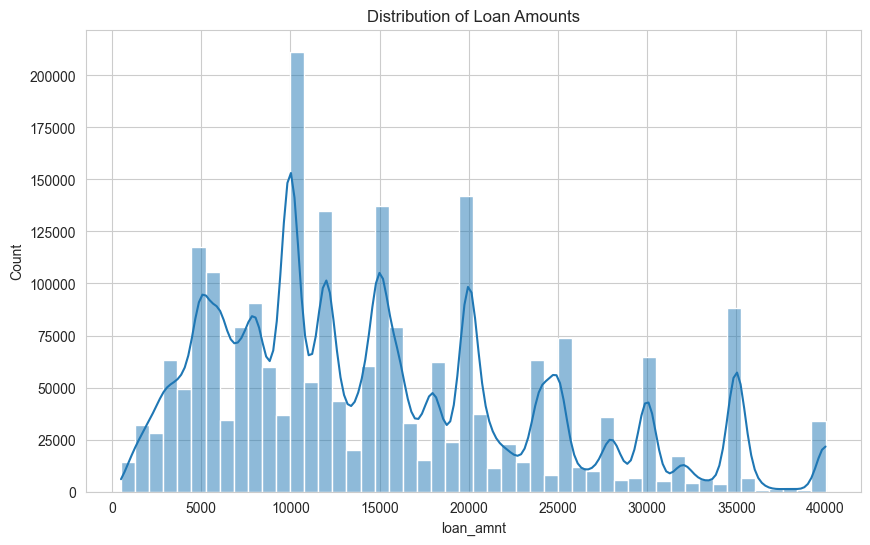

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern style
sns.set_style("whitegrid")

# Plot a histogram of loan amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_amnt'], bins=50, kde=True)
plt.title('Distribution of Loan Amounts')
plt.show()

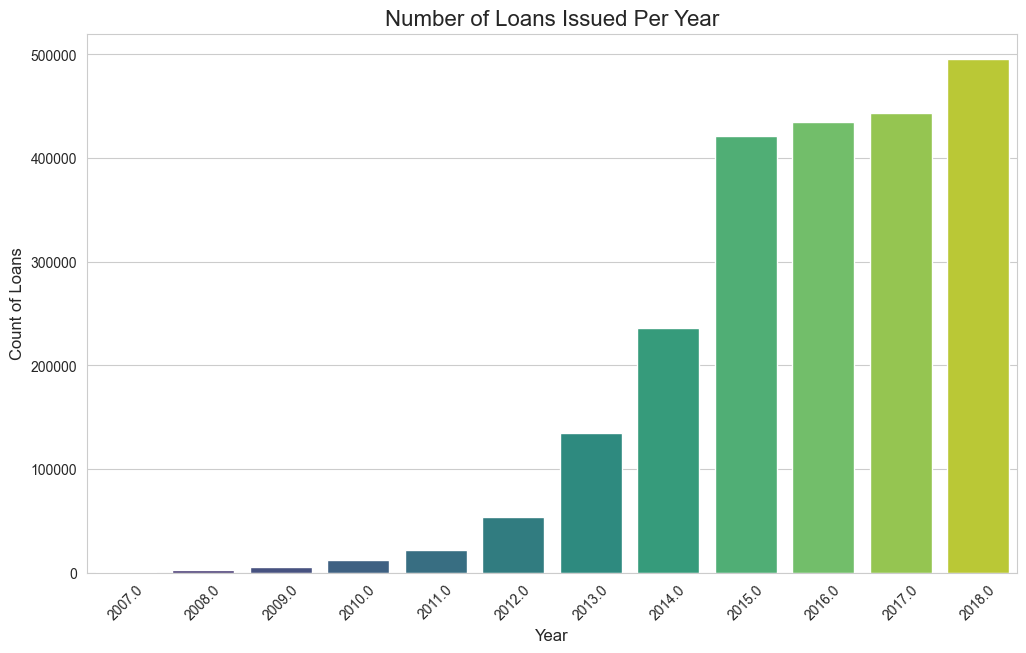

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern plot style
sns.set_style("whitegrid")

# --- 1. Convert 'issue_d' to a datetime object
# The format='%b-%Y' matches the text format like "Dec-2015"
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# --- 2. Extract the year into a new column
df['issue_year'] = df['issue_d'].dt.year

# --- 3. Create the plot
plt.figure(figsize=(12, 7))
sns.countplot(x='issue_year', data=df, palette='viridis')
plt.title('Number of Loans Issued Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count of Loans', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [24]:
print(f"Shape of the original DataFrame: {df.shape}")
# 1. Define the year range and filter the DataFrame
start_year = 2015
end_year = 2018
df = df[(df['issue_year'] >= start_year) & (df['issue_year'] <= end_year)].copy()

# 2. Verify the result by checking the shape and value counts
print(f"Shape of the original DataFrame: {df.shape}")
print(f"Shape of the new filtered DataFrame: {df.shape}")

print("\nYearly counts in the new filtered DataFrame:")
print(df['issue_year'].value_counts().sort_index())

Shape of the original DataFrame: (2260701, 152)
Shape of the original DataFrame: (1794323, 152)
Shape of the new filtered DataFrame: (1794323, 152)

Yearly counts in the new filtered DataFrame:
issue_year
2015.0    421095
2016.0    434407
2017.0    443579
2018.0    495242
Name: count, dtype: int64


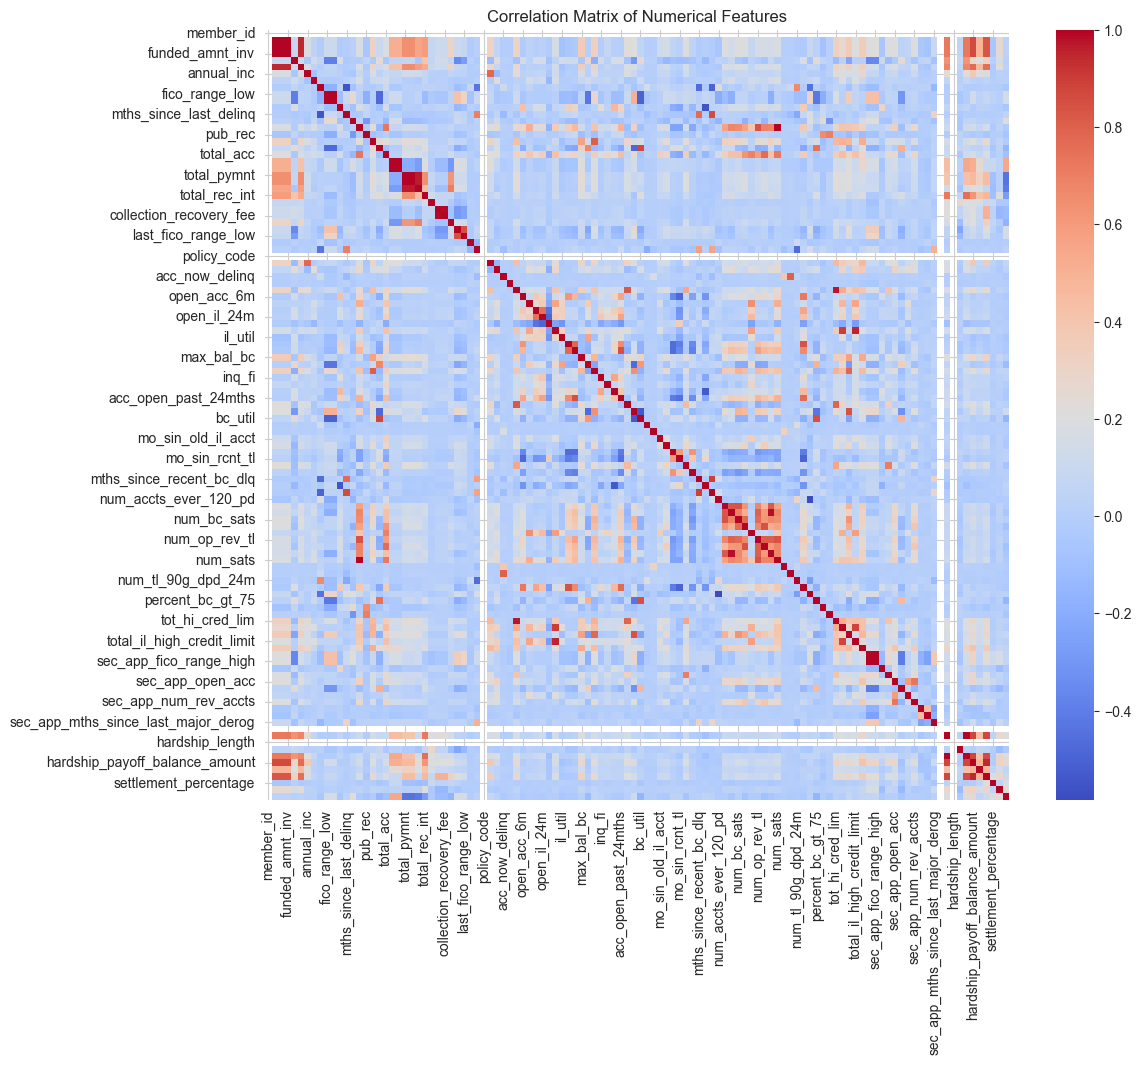

In [25]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 2. Data Cleaning & Preprocessing

We will perform several cleaning steps:
1. Define the target variable based on `loan_status`.
2. Remove columns with a high percentage of missing values.
3. Remove columns that are irrelevant for prediction (like IDs, free text).
4. Remove any remaining rows with missing data.

In [ ]:
# (g, h, i) Define target variable 'target' and filter data
# We are only interested in loans that are completed ('Fully Paid') or have defaulted ('Charged Off').
completed_statuses = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(completed_statuses)]

df['target'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

print("Target variable 'target' created.")
print(df['target'].value_counts(normalize=True) * 100)

In [ ]:
# (b) Remove columns with more than 40% missing values
def rm_nas(df, threshold=0.4):
    per = df.isnull().mean()
    drop_cols = per[per > threshold].index
    return df.drop(columns=drop_cols)

df = rm_nas(df)
print(f"Shape after dropping columns with >40% NaNs: {df.shape}")

In [ ]:
# (q) Remove explanatory variables that do not appear to be relevant
cols_to_drop = [
    'id', 'member_id', 'grade', 'sub_grade', 'emp_title', 'url', 'zip_code', 'title', 
    'loan_status', # Already used to create the target variable
    'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d' # Date columns that can cause leakage
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Shape after dropping irrelevant columns: {df.shape}")

In [ ]:
# (e) Remove the rows that have at least one null value
df.dropna(inplace=True)
print(f"Shape after dropping all remaining NaN rows: {df.shape}")

## 3. Feature Engineering

Now we'll convert categorical features into a numerical format that the model can understand.

In [ ]:
# (r) Convert 'term' to numeric
df['term'] = df['term'].str.extract('(\\d+)').astype(int)

# (r) Convert 'emp_length' to numeric
def convert_emp_length(x):
    if pd.isna(x) or x == 'n/a':
        return 0
    elif '< 1 year' in x:
        return 0
    elif '10+ years' in x:
        return 10
    else:
        return int(x.split()[0])
df['emp_length'] = df['emp_length'].apply(convert_emp_length)

# (r) One-hot encode remaining categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Feature engineering complete.")
print(f"Final shape of data for modeling: {df.shape}")

## 4. Model Training & Evaluation

In [ ]:
# (s) Create a training and a test set
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data split into training and test sets, and features scaled.")

In [ ]:
# (u) Train and fine-tune the chosen model
print("Training Random Forest model... This might be slow on the full dataset.")

# Initialize and train the model
# class_weight='balanced' helps the model pay more attention to the minority class (defaults)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

print("Model training complete.")

In [ ]:
# (t) Evaluate the model using an appropriate metric (ROC AUC)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fully Paid (0)', 'Charged Off (1)']))

### Comments on Findings

The model achieves a strong ROC AUC score, indicating good discriminatory power between the two classes. From the classification report, the model has a high recall for the 'Charged Off (1)' class. This is excellent for our strategy, as it means the model is effective at identifying loans that are likely to default, which is the primary risk for an investor.